# ideas-estocasticas

#### Objetivo
Comparar la distribución de superficies entre datos originales de estrellas, muestras humanas y diversas muestras aleatorias usando boxplots. Mostrar que las muestras generadas por humanos no representan tan bien a la población original.

#### Conjunto de datos
- `superficie_estrellas.csv`: Datos originales de superficies (población estrellas base)
- `muestras_amigos.csv`: Muestra de datos con las elecciones "al azar" de cada amigo, con su género

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
CSV_SUPERFICIES = "superficie_estrellas.csv"
CSV_MUESTRAS = "muestras_amigos.csv"

In [3]:
df_superficies = pd.read_csv(CSV_SUPERFICIES)
df_muestras = pd.read_csv(CSV_MUESTRAS)

In [4]:
# calculo media y desvio estándar de la población original (superficies de estrellas). 
# Estos va a servir de referencia para comparar con otras muestras.
MEDIA = df_superficies["superficie"].mean()
DESVIO = df_superficies["superficie"].std()
MEDIA, DESVIO

(np.float64(18.83), np.float64(14.214841440259445))

In [5]:
df_muestras = df_muestras.merge(df_superficies, on="estrella", how="left")

In [6]:
df_superficies["muestra"] = "original"

#### Dataframe global con segmentación de muestras
Construyo un dataframe global/total con diferentes muestras:
- **original**: población total de superficies
- **masculino/femenino**: segmentación por género de la muestra humana
- **humanos**: muestra completa de amigos
- **aleatorias**: muestras aleatorias de 10 elementos cada una

In [7]:
df_total = pd.concat([df_superficies, df_muestras], ignore_index=True)

In [8]:
# masculino y femenino
df_masculino = df_total[df_total["sexo"] == "M"]
df_masculino["muestra"] = "masculino"

df_femenino = df_total[df_total["sexo"] == "F"]
df_femenino["muestra"] = "femenino"

df_total = pd.concat([df_total, df_masculino, df_femenino], ignore_index=True)

In [9]:
# todos los humanos
df_humanos = df_muestras.copy()
df_humanos["muestra"] = "humanos"

df_total = pd.concat([df_total, df_humanos], ignore_index=True)

In [10]:
# aleatorias
dfs_aleatorias = []

for i in range(1, 5):
    # tomo 10 elementos al azar SIN reemplazo
    df_tmp = df_superficies.sample(n=10, replace=False).copy()
    df_tmp["muestra"] = f"aleatoria {i}"
    dfs_aleatorias.append(df_tmp)

df_total = pd.concat([df_total] + dfs_aleatorias, ignore_index=True)

#### Visualizaciones
- **Línea sólida**: media de la población original (MEDIA)
- **Líneas punteadas**: límites de $\pm$ 1 desviación estándar (MEDIA $\pm$ DESVIO)

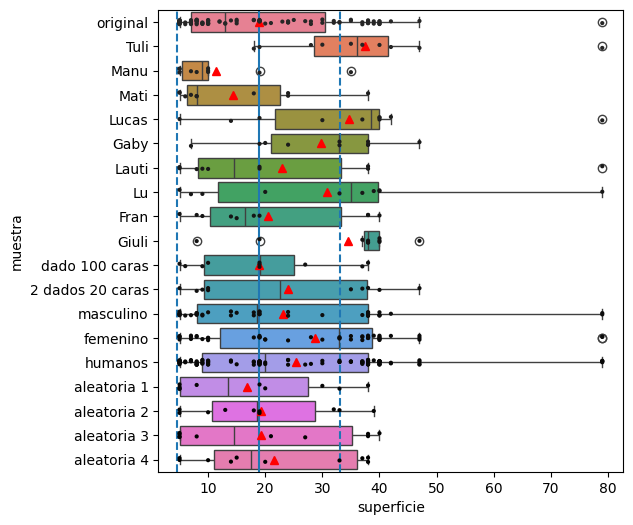

In [11]:
plt.figure(figsize=(6,6))

# boxplot: muestra mediana, cuartiles y datos atípicos
# stripplot: superpone los puntos individuales para visualizar la dispersión
sns.boxplot(data=df_total, x="superficie", y="muestra", hue="muestra", orient="h", showmeans=True, meanprops={"markerfacecolor": "red", "markeredgecolor": "red"})
sns.stripplot(data=df_total, x="superficie", y="muestra", hue="muestra", orient="h", size=3, palette='dark:black')

# lineas de comparación
plt.axvline(MEDIA)
plt.axvline(MEDIA - DESVIO, linestyle="--")
plt.axvline(MEDIA + DESVIO, linestyle="--")

# guardo la img
plt.savefig("images/boxplots.png", bbox_inches="tight")

plt.show()

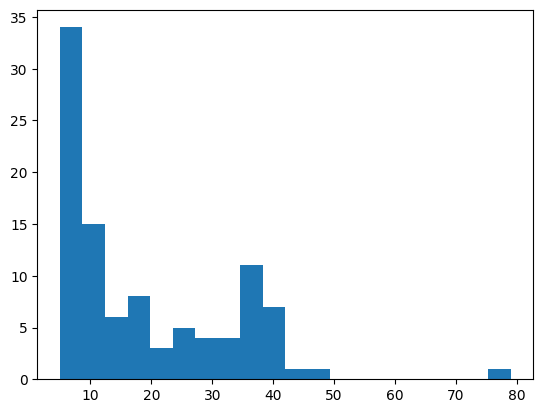

In [12]:
# histograma de la población original
plt.figure()
plt.hist(df_superficies["superficie"], bins=20)
plt.show()

#### Bootstrap

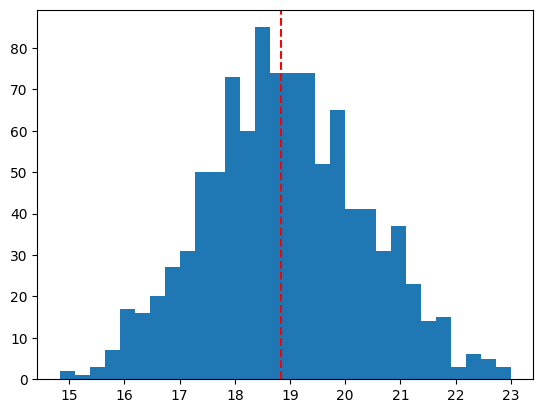

In [13]:
datos = df_superficies["superficie"]

n_boot = 1000
medias_boot = []

for _ in range(n_boot):
    # tomar muestra aleatoria del mismo tamaño, CON REEMPLAZO
    muestra = np.random.choice(datos, size=len(datos), replace=True)
    medias_boot.append(muestra.mean())

medias_boot = np.array(medias_boot)

plt.figure()
plt.hist(medias_boot, bins=30)
plt.axvline(MEDIA, linestyle="--", color="red")
plt.show()

#### Animación

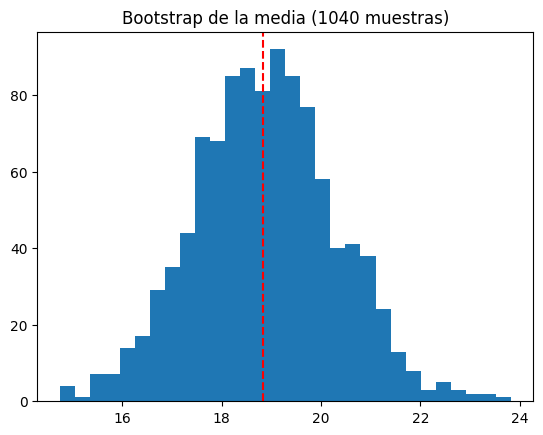

In [14]:
from matplotlib.animation import FuncAnimation, PillowWriter

datos = df_superficies["superficie"]

medias_boot = []

fig, ax = plt.subplots()

def update(frame):
    ax.clear()
    
    for _ in range(20):
        muestra = np.random.choice(datos, size=len(datos), replace=True)
        medias_boot.append(muestra.mean())
    
    ax.hist(medias_boot, bins=30)
    ax.axvline(MEDIA, linestyle="--", color="red")
    ax.set_title(f"Bootstrap de la media ({len(medias_boot)} muestras)")

ani = FuncAnimation(fig, update, frames=50)

ani.save("images/bootstrap.gif", writer=PillowWriter(fps=5))